<a href="https://colab.research.google.com/github/sdthtp/trafficSignClassification/blob/master/Traffic_Sign_Classification_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import zipfile
import pandas as pd
import tensorflow as tf
from tensorflow import keras # Tensorflow high-level api
from tensorflow.keras import layers
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Dense,Flatten, GlobalAveragePooling2D, BatchNormalization, Activation, Dropout, Conv2D,MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
#from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from datetime import datetime
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.layers import Input


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install kaggle
!pip install keras

In [ ]:
!cat > kaggle.json <<EOF
!echo '{"username":"hatipsedat","key":"645cde903abbd80d20dcaaa40b4ebe1d"}' > kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

/bin/bash: warning: here-document at line 0 delimited by end-of-file (wanted `EOF')


In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 98% 601M/612M [00:20<00:00, 35.9MB/s]
100% 612M/612M [00:20<00:00, 31.2MB/s]


In [ ]:
local_zip = '/content/gtsrb-german-traffic-sign.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/gtsrb')
zip_ref.close()

In [ ]:
# Generiere Bündel (batches) von Bilddaten-Tensoren mit echtzeit Datenaugmentierung.
# Die Daten werden in Bündel durchgelaufen (loop over in batches).
# 20 Prozent der Daten werden f ür die Validierung verwendet.


import cv2
trainfiles=open('/content/gtsrb/Train.csv').read().strip().split('\n')[1:] #Pro Zeile aufsplitten
#print(trainfile)
data=[]
labels =[]
IMG_PATH=[]
for i in range(len(trainfiles)):
    label,imagepath = trainfiles[i].split(',')[-2:] #Label und Imagepath aufsplitten
    imagepath=os.path.join("/content/gtsrb/",imagepath) #Path der CSV Datei dem Hauptpath anhängen
    IMG_PATH.append(imagepath) #PATH array jeweils alle paths hinzufügen
    image = cv2.imread(imagepath) #foto lesen
    image = cv2.resize(image,(128,128)) #trivial
    b,g,r = cv2.split(image)           
    image = cv2.merge([r,g,b]) #OpenCV liest Bilder im BGR Channel (warum auch immer), deshalb musste der Channel hier in RGB umgeändert werden
    data.append(image) #data array alle bilder hinzufügen
    labels.append(label) #die zugehörigen labels

    #IMG_PATH[image1.path, image2.path, image2.path, ..., imageN.path]
    #data[image1, image2, image3, ..., imageN]
    #labels[20, 10, 30, ..., label von imageN]


/content/gtsrb/Train/1/00001_00047_00020.png


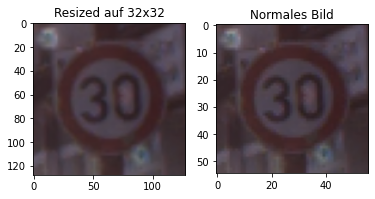

In [ ]:
print(IMG_PATH[2000])
plt.subplot(1,2,1)
plt.title("Resized auf 32x32")
plt.imshow(data[2000])
plt.subplot(1,2,2)
plt.title("Normales Bild")
plt.imshow(plt.imread(IMG_PATH[2000]))
plt.show()

In [ ]:
train_x, train_y = data,labels
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y,
                                                    stratify=train_y, 
                                                    test_size=0.2,
                                                    random_state = 7)
train_x = np.array(train_x)
train_y = np.array(train_y)
valid_x = np.array(valid_x)
valid_y = np.array(valid_y)
print(train_y.shape[0])
print(valid_y.shape[0])

31367
7842


In [ ]:
base_model = VGG16(include_top=False, weights="imagenet", input_tensor=Input(shape=(128, 128, 3)))
base_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)
for layer in base_model.layers:
  layer.trainable = False
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x) #new FC layer, random init
predictions = Dense(43, activation='softmax')(x) #new softmax layer
model = Model(inputs=base_model.input, outputs=predictions)

58892288/58889256 [==============================] - 5s 0us/step


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [ ]:
trainAugmentation = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        zoom_range=0.15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode="nearest"
)

In [ ]:
timestamp = datetime.now().strftime("%d-%b-%Y (%H:%M)")
filepath = "/content/drive/My Drive/VGG16_model_v" + timestamp + ".h5"
#model = load_model(filepath)

In [ ]:
#Optimizer/Compiler Block:

const_learning_rate = 0.0005
const_epochNum = 50
print("[INFO] Kompilierung...")
#decay=const_learning_rate / (const_epochNum * 0.5)
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(lr=const_learning_rate, decay=(1./0.75 -1)/32),
metrics=["accuracy"])

[INFO] Kompilierung...


In [ ]:
#Callback Funktion um zu sehen, um wie viel die LR mit LR-Decay pro Epoche abnimmt, funktioniert allerdings nicht wie erwartet, sondern gibt immer die Konstante LR an...
class printlearningrate(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lr = K.eval(optimizer.lr)
        Epoch_count = epoch + 1
        print('\n', "Epoch:", Epoch_count, ', LR: {:.10f}'.format(lr))
printlr = printlearningrate()

In [ ]:
#Trainingsblock
const_batch_size = 256
print("[INFO] Networktraining...")
history = model.fit_generator(
	trainAugmentation.flow(train_x, train_y, batch_size=const_batch_size),
	validation_data=(trainAugmentation.flow(valid_x, valid_y, batch_size=const_batch_size)),
	steps_per_epoch=train_x.shape[0] // const_batch_size,
	epochs=const_epochNum,
	callbacks = [printlr],
	verbose=1)
model.save(filepath) #--- Model wird in dieser Version nicht gesaved, damit es bei Ihnen auch funktioniert

[INFO] Networktraining...
Epoch 1/50
122/122 [==============================] - 115s 943ms/step - loss: 1.5328 - accuracy: 0.5809 - val_loss: 0.9709 - val_accuracy: 0.7399

 Epoch: 1 , LR: 0.0005000000
Epoch 2/50
122/122 [==============================] - 110s 900ms/step - loss: 0.8683 - accuracy: 0.7739 - val_loss: 0.7068 - val_accuracy: 0.7935

 Epoch: 2 , LR: 0.0005000000
Epoch 3/50
122/122 [==============================] - 109s 895ms/step - loss: 0.7246 - accuracy: 0.8194 - val_loss: 0.7354 - val_accuracy: 0.8082

 Epoch: 3 , LR: 0.0005000000
Epoch 4/50
122/122 [==============================] - 109s 891ms/step - loss: 0.6542 - accuracy: 0.8369 - val_loss: 0.5178 - val_accuracy: 0.8287

 Epoch: 4 , LR: 0.0005000000
Epoch 5/50
122/122 [==============================] - 109s 889ms/step - loss: 0.6053 - accuracy: 0.8519 - val_loss: 0.6336 - val_accuracy: 0.8430

 Epoch: 5 , LR: 0.0005000000
Epoch 6/50
122/122 [==============================] - 111s 910ms/step - loss: 0.5703 - accurac

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
testfiles=open('/content/gtsrb/Test.csv').read().strip().split('\n')[1:] #Pro Zeile aufsplitten
data=[]
labels =[]
IMG_PATH=[]
for i in range(len(testfiles)):
    label,imagepath = testfiles[i].split(',')[-2:] #Label und Imagepath aufsplitten
    imagepath=os.path.join("/content/gtsrb/",imagepath) #Path der CSV Datei dem Hauptpath anhängen
    IMG_PATH.append(imagepath) #PATH array jeweils alle paths hinzufügen
    image = cv2.imread(imagepath) #foto lesen
    image = cv2.resize(image,(32,32)) #trivial
    b,g,r = cv2.split(image)           
    image = cv2.merge([r,g,b]) #OpenCV liest Bilder im BGR Channel (warum auch immer), deshalb musste der Channel hier in RGB umgeändert werden
    data.append(image) #data array alle bilder hinzufügen
    labels.append(label) #die zugehörigen labels

test_x, test_y = data,labels
test_x = np.array(test_x)
test_y = np.array(test_y)

In [ ]:
#Test_Data wird normalisiert für korrekte Evaluierung
test_augmented = np.zeros((test_x.shape[0],32,32,3))
for i in range(test_x.shape[0]):
  test_augmented[i] = test_x[i]/255.0
test_x = test_augmented

In [ ]:
#Um mit eigenen Bildern zu testen

"""
image = cv2.imread('/content/drive/My Drive/EigeneTests/sample1.PNG')
image = cv2.resize(image,(32,32)) #trivial
b,g,r = cv2.split(image)           
image = cv2.merge([r,g,b]) #OpenCV liest Bilder im BGR Channel (warum auch immer), deshalb musste der Channel hier in RGB umgeändert werden
image = np.array(image)
plt.imshow(image)
image = np.expand_dims(image, axis=0)
plt.show()
pred = model.predict(image/255)
print("Predicted Label: " + str(np.argmax(pred, axis=1)) + ". Confidence: " + str(pred[0][np.argmax(pred,axis=1)])) #argmax, da wir die Zeile mit der höchsten Wahrscheinlichkeit nehmen (softmax)
if (np.argmax(pred, axis=1) == 1):
  print("It is a 30km/h speed limit sign!")
else:
  print("It is another sign")

  """

In [ ]:
#Evaluierung
evaluation = model.evaluate(
    x=test_x, y=test_y, batch_size=const_batch_size, verbose=1, sample_weight=None, steps=None,
  callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False
)
sampleExcelRow = 55
#pred = model.predict(image/255)
pred = model.predict(test_x[sampleExcelRow - 2:sampleExcelRow - 1]) #9:10 = 11 in excel
print(model.metrics_names)
print(evaluation)
arg = np.argmax(pred, axis = 1)
print(arg) #printet das label der 55 excel reihe in Test.csv